In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
%%html
<style> 
th{
    font-size: 20px;
    font-weight: bold;
}

td{
    font-size: 18px;
}
</style>

# La convolution

## Introduction
Ce document vise à rendre le lecteur familier avec l’opération de convolution, de sa définition à son calcul en passant par quelques unes de ses propriétés. Au premier abord, la convolution semble parfois difficile à saisir. Une des raisons est le fait que l’on doit recourir à des fonctions particulières – les impulsions de Dirac – afin de définir formellement la convolution sous la forme d’une intégrale. Une autre raison est l’interprétation même de cette intégrale lorsqu’on doit la calculer. Le présent document vise à montrer toute la pertinence de cet opérateur mathématique, et à en donner une interprétation intuitive. On donnera aussi des exemples numériques montrant comment on peut évaluer la convolution avec Python.

Il y a essentiellement 3 approches pour obtenir la réponse d’un système linéaire (comme un filtre, par exemple) à une entrée donnée. Il s’agit de :

>**Résoudre l’équation différentielle du système.** L’équation du système doit alors être connue, et il doit être possible de la résoudre avec les méthodes connues. Si le système est un filtre linéaire d’ordre 1 – par exemple un circuit RC – alors son équation différentielle est simple et facile à résoudre. Vous devriez déjà être familier avec cette approche.

**ou**

>**Utiliser l’approche par transformée.** Dans ce cas, on doit transformer l’équation du système, de même que les signaux eux-mêmes. Spécifiquement, on applique alors la Transformée de Laplace au signal d’entrée de même qu’à l’équation différentielle du système. En manipulant ces fonctions dans le domaine transformé, puis en appliquant la transformation inverse, on obtient alors l’expression temporelle du signal de sortie. Nous y reviendrons.

**ou**

>**Appliquer l’opération de convolution.**  Il s’agit alors d’appliquer une intégrale – l’intégrale de convolution – faisant intervenir le signal d’entrée du système $x(t)$ ainsi que sa réponse impulsionnelle $h(t)$. Cette approche fait l’objet du présent document.


## Systèmes LTI

Pour que l’opération de convolution ait un sens, elle doit être appliquée à un système qui a deux propriétés :

1. le système doit être linéaire
2. le système doit être invariant dans le temps

Dans la littérature (la plupart du temps, en anglais) on nomme LTI (« Linear Time Invariant ») ce type de systèmes. Tous les filtres que nous allons rencontrer ont cette propriété.

Un système est linéaire si multiplier l’entrée par un gain $g$ a pour unique effet de multiplier la sortie associée par le même gain $g$ :

| Signal d’entrée | Signal de sortie |
|----|----|
| $x(t)$   | $y(t)$  |
| $g \ x(t)$  | $g \ y(t)$ |


Un système est invariant dans le temps si, en introduisant un décalage $t_0$ dans le signal d’entrée, l’unique effet est de décaler de $t_0$ le signal de sortie, sans en changer la forme d’autre façon :


| Signal d’entrée | Signal de sortie |
|----|----|
| $x(t)$   | $y(t)$  |
| $x(t-t_0)$  | $y(t-t_0)$ |


Si un système répond simultanément à ces deux conditions, alors on le qualifie de système LTI et on peut appliquer la convolution pour évaluer la réponse à une entrée donnée.

## Concepts de base

Avant de se lancer dans l’étude de la convolution, et des fonctions de Dirac $\delta(t)$ dont elle se nourrit, commençons par le commencement.

Le point de départ est celui de la « boite noire ». Considérez le schéma suivant 

<img src="Images/05_FiltreBoiteNoire.png" width="480px" height="400px">

**Figure 1**:  Schéma générique d’un système LTI.


Ici, $x(t)$ est l’entrée du système, $y(t)$ est se sortie (la réponse à l’entrée $x(t)$ ) et le système lui-même est dénoté $H$. Cette notation est conforme à celle des fonctions de transfert, c’est pourquoi on l’utilise tout de suite. (On aurait pu appeler le système « Charlie », mais c’est à la fois trop long à écrire tout le temps, et en plus ça fait familier…)

Le système $H$ pourrait être, par exemple, un filtre passif ou un filtre actif, ou toute autre opération de type LTI. Mais ici, on ne connaît pas sa nature. On sait par contre (parce qu’on l’a mesuré) que, si l’entrée du système $H$ est une onde rectangulaire d’amplitude 1 et de durée 1 seconde, alors sa sortie est telle que montrée sur la figure ci-dessous.


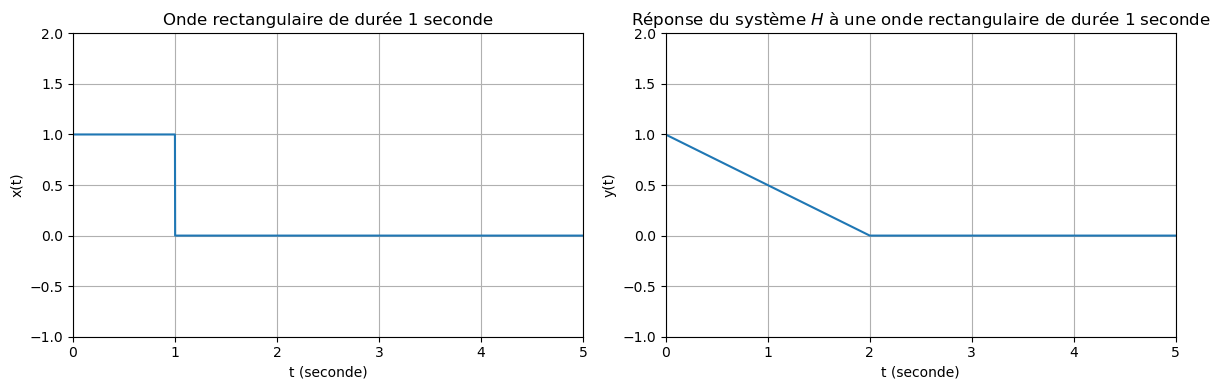

In [3]:
dt = 1/1000     # incrément temporel (élément différentiel)
t = np.arange(0, 5, dt)     # échelle de temps

x = np.piecewise(t, [t < 1, t >= 1], [1, 0])    # signal d’entrée (version discrète)
y = np.piecewise(t, [t < 2, t >= 2], [lambda t: -0.5*t+1, 0])   # signal de sortie (version discrète)

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.plot(t,x)
ax1.set_ylim([-1, 2])
ax1.set_xlim([0, 5])
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t (seconde)")
ax1.set_title("Onde rectangulaire de durée 1 seconde")
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(t,y)
ax2.set_ylim([-1, 2])
ax2.set_xlim([0, 5])
ax2.set_ylabel("y(t)")
ax2.set_xlabel("t (seconde)")
ax2.set_title("Réponse du système $H$ à une onde rectangulaire de durée 1 seconde")
ax2.grid()

plt.tight_layout()

**Figure 2** :  Réponse du système $H$ à une onde rectangulaire de durée 1 seconde.

(On ne risque pas de rencontrer de système ayant ce type de réponse dans la nature, mais nous prenons des formes simples pour illustrer les idées.)

Sachant que le système $H$ est LTI, quelle serait alors sa réponse si l’entrée $x(t)$, pour lequel on a mesuré la réponse à la Figure ci-dessus, était remplacée par $1.5 \ x(t)$? La linéarité du système produit le résultat de la figure suivante.

<img src="Images/05_FiltreBoiteNoire.png" width="480px" height="400px">

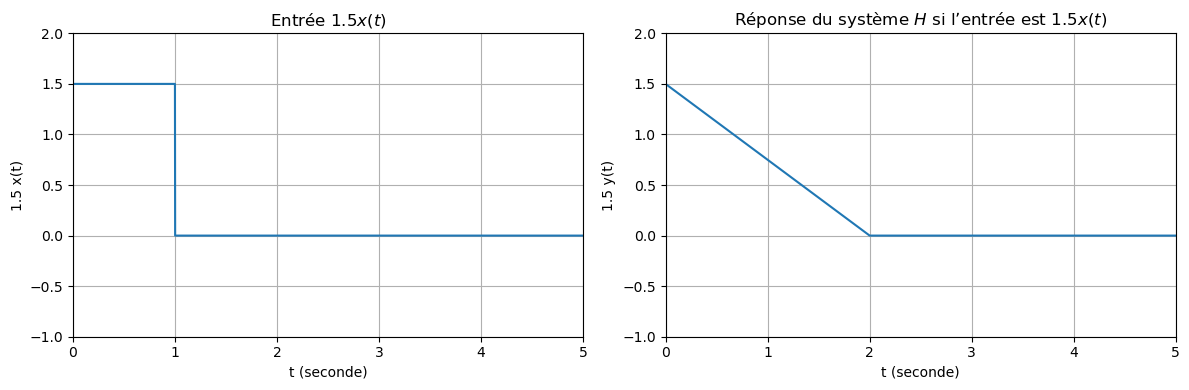

In [4]:
dt = 1/1000  # incrément temporel (élément différentiel) 
t = np.arange(0, 5, dt) # échelle de temps

x = np.piecewise(t, [t < 1, t >= 1], [1, 0])    # signal d’entrée (version discrète)
y = np.piecewise(t, [t < 2, t >= 2], [lambda t: -0.5*t+1, 0])   # signal de sortie (version discrète)

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.plot(t, 1.5*x)
ax1.set_ylim([-1, 2])
ax1.set_xlim([0, 5])
ax1.set_ylabel("1.5 x(t)")
ax1.set_xlabel("t (seconde)")
ax1.set_title("Entrée $1.5x(t)$")
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(t, 1.5*y)
ax2.set_ylim([-1, 2])
ax2.set_xlim([0, 5])
ax2.set_ylabel("1.5 y(t)")
ax2.set_xlabel("t (seconde)")
ax2.set_title("Réponse du système $H$ si l’entrée est $1.5 x(t)$")
ax2.grid()

plt.tight_layout()



**Figure 3** :   Réponse du système $H$ si l’entrée est $1.5 x(t)$.

Maintenant, quelle sera la réponse du système si on retarde l’entrée $x(t)$ de 2 secondes? Autrement dit, le signal d’entrée est maintenant donné par $x(t-2)$. Puisqu’on assume que le système est invariant dans le temps, la forme de la réponse ne devrait pas être changée. Elle devrait seulement être décalée, du même décalage que le signal d’entrée (ici, 2 secondes).

Ceci est montré à la figure suivante.

<img src="Images/05_FiltreBoiteNoire.png" width="480px" height="400px">


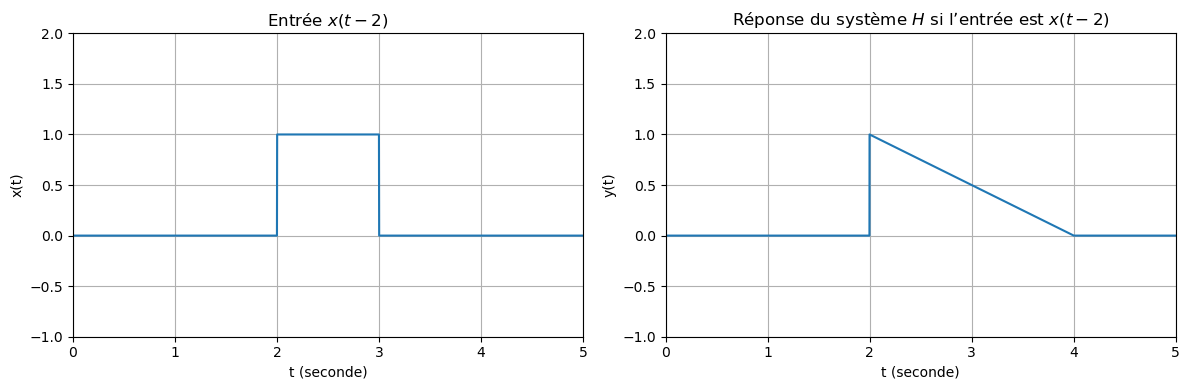

In [5]:
dt = 1/1000  # incrément temporel (élément différentiel) 
t = np.arange(0, 5, dt) # échelle de temps

x = np.piecewise(t, [t < 1, t >= 1], [1, 0])    # signal d’entrée (version discrète)
y = np.piecewise(t, [t < 2, t >= 2], [lambda t: -0.5*t+1, 0])   # signal de sortie (version discrète)

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.plot(t, np.roll(x, int(2/dt)))
ax1.set_ylim([-1, 2])
ax1.set_xlim([0, 5])
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t (seconde)")
ax1.set_title("Entrée $x(t-2)$")
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(t, np.roll(y, int(2/dt)))
ax2.set_ylim([-1, 2])
ax2.set_xlim([0, 5])
ax2.set_ylabel("y(t)")
ax2.set_xlabel("t (seconde)")
ax2.set_title("Réponse du système $H$ si l’entrée est $x(t-2)$")
ax2.grid()

plt.tight_layout()

**Figure 4** :   Réponse du système $H$ si l’entrée est $x(t−2)$.

On se doute fort que si l’entrée est maintenant formée de la somme de $x(t)$ (comme dans la figure 2) et de $x(t-2)$ (comme dans la figure 4), alors la réponse sera formée de la somme des deux réponses respectives. Ceci est montré à la figure suivante.

<img src="Images/05_FiltreBoiteNoire.png" width="480px" height="400px">

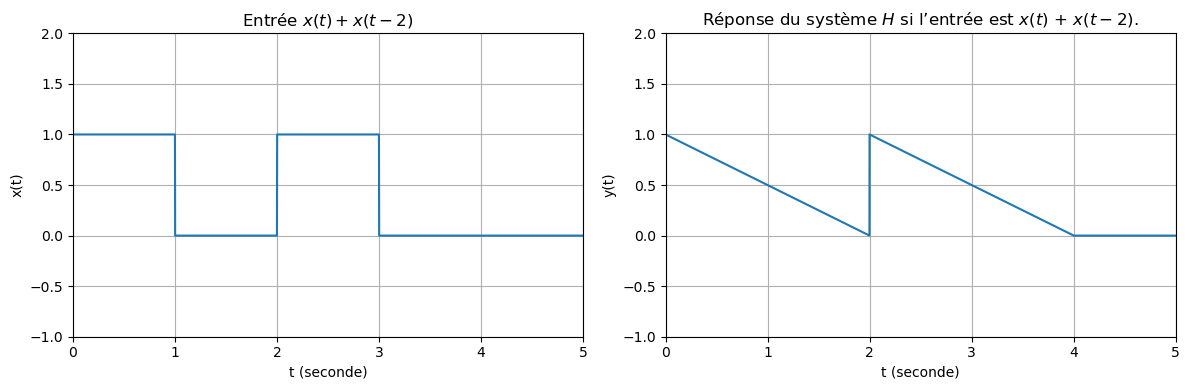

In [6]:
dt = 1/1000  # incrément temporel (élément différentiel) 
t = np.arange(0, 5, dt) # échelle de temps

x = np.piecewise(t, [t < 1, t >= 1], [1, 0])    # signal d’entrée (version discrète)
y = np.piecewise(t, [t < 2, t >= 2], [lambda t: -0.5*t+1, 0])   # signal de sortie (version discrète)

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.plot(t, x + np.roll(x, int(2/dt)))
ax1.set_ylim([-1, 2])
ax1.set_xlim([0, 5])
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t (seconde)")
ax1.set_title("Entrée $x(t) + x(t-2)$")
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(t, y + np.roll(y, int(2/dt)))
ax2.set_ylim([-1, 2])
ax2.set_xlim([0, 5])
ax2.set_ylabel("y(t)")
ax2.set_xlabel("t (seconde)")
ax2.set_title("Réponse du système $H$ si l’entrée est $x(t)$ + $x(t-2)$.")
ax2.grid()

plt.tight_layout()

**Figure 5** :   Réponse du système H si l’entrée est x(t) + x(t−2).

Qu’est-ce qui se passe maintenant si les réponses individuelles sont superposées? Autrement dit, si on a en entrée une série d’impulsions rectangulaires dont la réponse est plus longue que l’espacement entre les impulsions? Puisque le système est linéaire, la réponse à une somme d’impulsions décalées est la somme des réponses (même si ces réponses se superposent). Et puisque le système est invariant dans le temps, la forme des réponses individuelles est la même, à un décalage près.

Ainsi, la réponse à deux impulsions successives de durée 1 seconde et d’amplitude 1 est telle que montrée à la figure suivante.

<img src="Images/05_FiltreBoiteNoire.png" width="480px" height="400px">

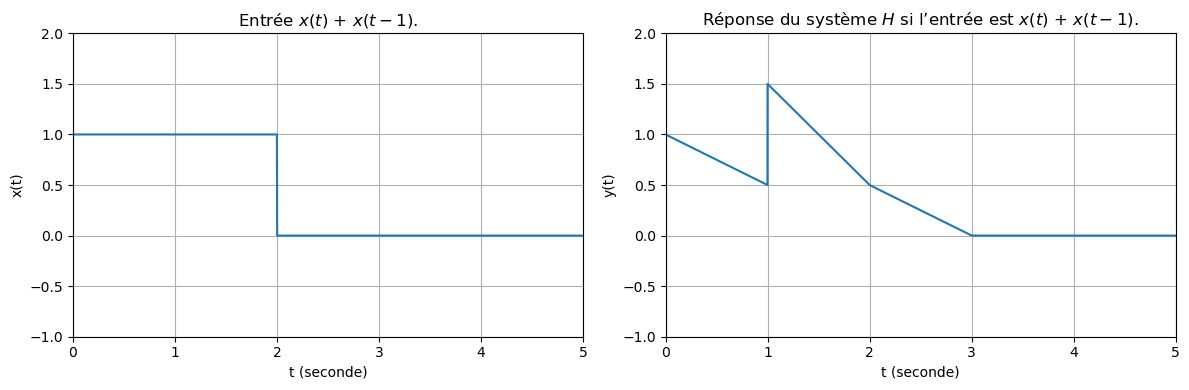

In [7]:
dt = 1/1000  # incrément temporel (élément différentiel) 
t = np.arange(0, 5, dt) # échelle de temps


x = np.piecewise(t, [t < 1, t >= 1], [1, 0])     # signal d’entrée (version discrète)
y = np.piecewise(t, [t < 2, t >= 2], [lambda t: -0.5*t+1, 0])   # signal de sortie (version discrète)

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.plot(t, x + np.roll(x, int(1/dt)))
ax1.set_ylim([-1, 2])
ax1.set_xlim([0, 5])
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t (seconde)")
ax1.set_title("Entrée $x(t)$ + $x(t-1)$.")
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(t, y + np.roll(y, int(1/dt)))
ax2.set_ylim([-1, 2])
ax2.set_xlim([0, 5])
ax2.set_ylabel("y(t)")
ax2.set_xlabel("t (seconde)")
ax2.set_title("Réponse du système $H$ si l’entrée est $x(t)$ + $x(t-1)$.")
ax2.grid()

plt.tight_layout()


**Figure 6.**  Réponse du système $H$ si l’entrée est $x(t)$ + $x(t-1)$. Notez que les réponses individuelles se superposent.


Cette réponse est la somme de la réponse $y(t)$ à la figure 2, et de la même réponse mais décalée de 1 seconde (i.e. $y(t-1)$). (Une réponse de forme bizarre, mais souvenez-vous que la réponse de la figure 2, pour une impulsion rectangulaire en entrée, n’a pas la forme que l’on retrouverait pour un système « normal » -- on utilise ici des formes simples pour illustrer les concepts de base).

A la figure 6, on observe qu’on peut remplacer une impulsion rectangulaire de durée 2 secondes, par la somme de 2 impulsions rectangulaires de durée 1 seconde, et calculer la réponse en faisant la somme (en fait la superposition) des réponses décalées aux impulsions de durée 1 seconde. C’est le principe fondamental qui mène à la convolution.

Pourrait-on, en connaissant la réponse à une impulsion rectangulaire de durée 1 seconde, obtenir de cette façon la réponse à n’importe quel autre signal, même un signal dont la forme n’est pas une suite d’impulsions rectangulaires? Par exemple, quelle serait la réponse à l’entrée dans la figure 7?

<img src="Images/05_FiltreBoiteNoire.png" width="480px" height="400px">


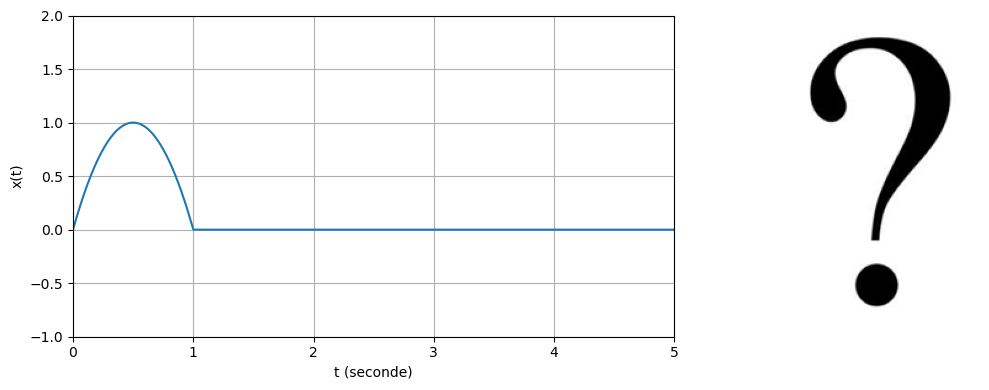

In [11]:
dt = 1/1000  # incrément temporel (élément différentiel) 
t = np.arange(0, 5, dt) # échelle de temps

x = np.piecewise(t, [t < 1, t >= 1], [lambda t: -4*t**2+4*t, 0])     # signal d’entrée (version discrète)

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.plot(t, x)
ax1.set_ylim([-1, 2])
ax1.set_xlim([0, 5])
ax1.set_ylabel("x(t)")
ax1.set_xlabel("t (seconde)")
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.imshow(plt.imread("./Images/05_interrogation.png"))
ax2.set_axis_off()


plt.tight_layout()


**Figure 7.**  Le système $H$, dont l’entrée $x(t)$ est maintenant une onde de forme quelconque.


Et bien, non. On ne pourrait pas obtenir la réponse du système H à cette entrée de forme quelconque (en fait, plutôt arrondie) en connaissant uniquement la réponse à une impulsion rectangulaire de durée 1 seconde, montrée à la figure 2. La raison est qu’il n’est pas possible de remplacer le signal d’entrée $x(t)$ de la figure 7 par une somme d’impulsions rectangulaires décalées, chacune de durée 1 seconde. Par contre, en connaissant la réponse du système à une impulsion de Dirac, alors on pourrait déterminer la réponse à n’importe quelle entrée, en appliquant les mêmes concepts que nous venons de voir. Une impulsion de Dirac est essentiellement une impulsion rectangulaire de durée « nulle », d’amplitude « infinie », et dont la surface demeure égale à 1. En appliquant une intégrale particulière, appelée intégrale de convolution, qui fait intervenir le signal d’entrée $x(t)$ et la réponse du système à l’impulsion de Dirac, on peut alors calculer la réponse à tout signal d’entrée.

Nous allons voir cela dans la prochaine section.


## La convolution
Une fonction importante dans l’analyse des signaux à temps continu est l’impulsion de Dirac, notée $\delta (t)$. Cette fonction se représente, théoriquement, comme ayant une amplitude infinie au temps $t = 0$, et ayant une amplitude nulle pour toutes les autres valeurs de $t$. Mais en même temps, la fonction $\delta (t)$ a la particularité que la surface sous sa courbe vaut 1. Mathématiquement, la fonction $\delta (t)$ s’exprime comme suit :

$$
\delta(t)=0 \quad \text { pour } t \neq 0
$$
et
$$
\int_{t=-\infty}^{\infty} \delta(t) d t=1
$$

En termes clairs : l’impulsion $\delta (t)$ est nulle partout sauf à $t = 0$, mais la surface totale sous la courbe de $\delta (t)$ vaut 1. On peut donc visualiser l’impulsion $\delta (t)$ comme un rectangle centré à $t=0$, de largeur infinitésimale $\epsilon$ et de hauteur « infinie » $1/\epsilon$. 

Puisque, de façon générale, l’impulsion $\delta (t-t0)$ – i.e. l’impulsion  retardée de $t_0$ secondes – est nulle partout sauf à $t=t_0$, on peut écrire :

$$
x(t) \delta\left(t-t_0\right)=x\left(t_0\right) \delta\left(t-t_0\right)
$$

ce qui signifie que multiplier entre elles les fonctions (continues) $x(t)$ et $\delta\left(t-t_0\right)$ revient à multiplier I'impulsion $\delta\left(t-t_0\right)$ par la valeur de $x(t)$ évaluée à $t=t_0$.

Ainsi, pour obtenir la valeur $x\left(t_0\right)$, il suffit d'intégrer le produit de fonctions $x(t) \delta\left(t-t_0\right)$ sur tout I'intervalle du temps. Il s'agit d'une des propriétés importantes de la fonction impulsion $\delta(t)$ (propriété d'échantillonnage), qui s'énonce comme suit :
$$
x\left(t_0\right)=\int_{t=-\infty}^{\infty} x(t) \delta\left(t-t_0\right) d t
$$
Cette équation s'interprète comme suit: en multipliant une fonction $x(t)$ par une impulsion une impulsion décalée $\delta\left(t-t_0\right)$, puis en intégrant ce produit de fonctions sur toute I'échelle du temps, on obtient $x\left(t_0\right)$, la valeur de la fonction $x(t)$ évaluée au temps $t=t_0$.

Maintenant, quand j'écris $x\left(t_0\right) \delta\left(t-t_0\right)$, il s'agit bien d'une fonction définie sur tout I'intervalle du temps. En fait, c'est I'impulsion $\delta\left(t-t_0\right)$, dont la surface totale vaut 1 (tel que discuté au début de cette section), multipliée par $x\left(t_0\right)$. Que se passe-t-il si je met les unes à côté des autres ces fonctions $x\left(t_0\right) \delta\left(t-t_0\right)$, où je fais varier de façon infinitésimale $t_0$ d'une fonction à la suivante? J’obtiens une série d’impulsions infiniment proches les unes des autres, dont l’intensité (la surface) de chacune est proportionnelle à l’amplitude du signal $x(t)$ à la position $t_0$ où se trouve I'impulsion. où se trouve l’impulsion. Il n’y a qu’un pas à faire pour remplacer tout le signal $x(t)$ par la somme de ces impulsions décalées et d’amplitudes proportionnelles au signal, c’est de faire la « somme » (en fait on verra que c’est l’intégrale – la limite d’une somme) de chaque impulsion décalée, multipliée par la largeur (infinitésimale) de chaque impulsion et multipliée par l’amplitude du signal $x(t)$ à la position où se situe chaque impulsion. 

Appelons $\tau$ la position d’une impulsion donnée et $d\tau$ la largeur infinitésimale de chaque impulsion. Alors, l’amplitude du signal $x(t)$ au temps $t=\tau$ est $x(\tau)$ et l’impulsion de Dirac décalée de $\tau$ est $\delta(t-\tau)$. (On utilise $\tau$ est non $t_0$ pour signifier le décalage pour simplifier la notation de ce qui va suivre). Avec ces définitions, faire la somme (en fait l’intégrale) des impulsions décalées, multipliées par leur largeur $\tau$ et par l’amplitude du signal $x(t)$ à cette position revient à l’intégrale suivante :

$$
x(t)=\int_{\tau=-\infty}^{\infty} x(\tau) \delta(t-\tau) d \tau
$$

Pourquoi toutes ces complications, dites-vous, si on connaît déjà le signal $x(t)$ ? Pourquoi le remplacer par cette intégrale bizarre, qui fait intervenir des fonctions impulsions $\delta(t-\tau)$ d'amplitude infinie et de largeur infinitésimale?

Et bien, voici la magie. Imaginez qu'on a calculé ou mesuré la réponse du système à une impulsion $\delta(t)$ en entrée, i.e. une impulsion de Dirac agissant uniquement à $t=0$. Et appelons $h(t)$, comme c'est I'usage, cette réponse du système à une impulsion (on dit aussi réponse impulsionnelle). Comme on fait I'hypothèse que le système est linéaire et invariant dans le temps (LTI), alors si on a une somme d'impulsions décalées en entrée, on aura en sortie la somme des réponses impulsionnelles décalées. Comme les impulsions sont d'amplitude infinie et de largeur infinitésimale, cette «somme» s'exprime encore comme une intégrale. En clair, si on veut la réponse du système à une entrée $x(t)$ quelconque, il suffit de remplacer les impulsions $\delta(t-\tau)$ dans I'intégrale ci-dessus par la réponse individuelle de chaque impulsion, i.e. $h(t-\tau)$. Ainsi, la réponse $y(t)$ d'un système LTI à toute entrée $x(t)$ s'exprime :

<div class="alert alert-block alert-info">
Intégrale de convolution :
    
$$y(t)=\int_{\tau=-\infty}^{\infty} x(\tau) h(t-\tau) d \tau $$
</div> 

Cette intégrale porte un nom bien particulier : il s'agit de l'intégrale de convolution. Elle exprime la relation entrée-sortie de tout système LTI si on connaît son entrée $x(t)$ et sa réponse impulsionnelle $h(t)$.

L'intégrale de convolution est importante et doit être maîtrisée. Par exemple, comment la calcule-t-on avec des exemples précis de signaux $x(t)$ et $h(t)$ ? Et quelles sont ses propriétés principales? C'est ce que nous allons voir dans les prochaines sections.

## La convolution pour les signaux à temps discret

Un peu comme les séries de Fourier qui sont plus faciles à comprendre que la transformée de Fourier (une somme d’harmoniques est plus facile à concevoir que l’intégrale de Fourier), la convolution se comprend beaucoup plus aisément dans le domaine du temps discret (suite d’échantillons) que dans le domaine du temps continu. La somme de convolution (très facile à comprendre) pour un signal à temps discret a la même forme que l’intégrale de convolution pour les signaux à temps continu. Ses propriétés sont aussi très similaires.

Nous allons donc faire une petite incartade du côté des signaux à temps discret pour aider notre compréhension. De plus, comme nous allons utiliser Python pour approximer l’intégrale de convolution, autant bien comprendre la convolution sur des signaux à temps discret (réalisée par la fonction *convolve* de la librairie Python Numpy).

Un signal à temps discret est un signal qui ne peut prendre de valeurs qu’à des instants discrets du temps. Ainsi, le signal $x[nT]$ est un signal à temps discret, dont l’intervalle temporel entre les échantillons est T (période d’échantillonnage). L’entier $n = …, -2, -1, 0, 1, 2, … $ permet de numéroter les échantillons successifs, qui se trouvent aux temps discrets $t = …, -2T, -T, 0, T, 2T, … $ Pour simplifier la notation, on écrit simplement $x[n]$ au lieu de $x[nT]$, en se rappelant toutefois que lorsqu’on écrit $x[n]$, on veut dire le signal $x(t)$ évalué au temps $t=nT$.

Un des avantages des signaux à temps discret est qu’une impulsion de Dirac n’a plus à avoir une hauteur infinie, puisque la notion de « largeur » de l’impulsion n’a aucun sens dans un signal discret. L’impulsion de Dirac discrète sera simplement un signal qui vaut $0$ à tous ses échantillons, sauf un seul qui vaudra $1$. Tout simplement.

Soit donc le système LTI à temps discret de la figure suivante :

<div style="text-align: center;">

![alt text](./Images/05_discret_LTI.png "fig 7")

</div>

où les signaux $x[n]$ et $y[n]$ sont simplement des séries d’échantillons (des vecteurs Numpy, par exemple).

Supposons maintenant que la réponse à l’impulsion discrète

$$
x[n]=\delta[n]= \begin{cases}0 & \text { pour } n \neq 0 \\ 1 & \text { pour } n=0\end{cases}
$$

est

$$
y[n]=h[n]=\left\{\begin{array}{lr}
1 & \text { pour } n=0,1 \text { et } 2 \\
0 & \text { ailleurs }
\end{array}\right.
$$

(On utilise la notation réservée $\delta[n]$ pour l’impulsion de Dirac discrète, et $h[n]$ pour la réponse à l’impulsion (ou réponse impulsionnelle) du système, puisque ce sont des fonctions spéciales, et importantes, pour décrire un système.)

On a donc graphiquement :

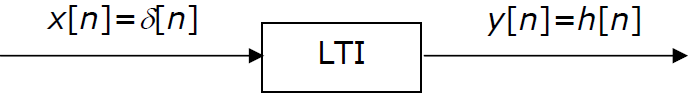

In [ ]:
n = np.arange(-2, 6, 1)

x = np.array([0,0,1,0,0,0,0,0])
y = np.array([0,0,1,1,1,0,0,0])

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.stem(n, x)
ax1.set_ylim([-0.5, 1.5])
ax1.set_xlabel("n")
ax1.set_title('Entrée $x[n]=\delta[n]$')


ax2 = plt.subplot(1,2,2)
ax2.stem(n, y)
ax2.set_ylim([-0.5, 1.5])
ax2.set_xlabel("n")
ax2.set_title('Sortie $y[n]=h[n]$')

plt.tight_layout()


**Figure 8.** Exemple de réponse à l’impulsion d’un système discret.

Quelle serait maintenant la sortie $y[n]$ si l’entrée était plutôt telle que montrée dans la figure suivante:

In [ ]:
n = np.arange(-2, 6, 1)

x = np.array([0,0,1,1,1,0,0,0])

fig = plt.figure()
plt.stem(n, x)
plt.ylim([-0.5, 1.5])
plt.xlabel("n")
plt.title('Entrée $x[n]$')

plt.tight_layout()

Pour obtenir la réponse, il faut appliquer le principe de superposition des systèmes LTI (qu'ils soient discrets ou non), qui dit que la réponse d'une somme est la somme des réponse individuelles. Ainsi, le signal $x[n]$ de la figure ci-haut est la somme de 3 impulsions décalées, la première à $n=0$, la seconde à $n=1$ et la troisième à $n=2$. La réponse à cette somme de 3 impulsions décalées sera donc la somme des réponses individuelles. Comme le système est Invariant dans le Temps $(«TI»)$, la forme de la réponse ne dépend pas du moment où on applique I'entrée. Ainsi, la réponse $y[n]$ à I'entrée $x[n]$ montrée ci-haut devrait être la somme des trois signaux suivants:
$$
\begin{array}{llllllllll}
    n & -2 & -1 & 0 & 1 & 2 & 3 & 4 & 5 & 6 \ldots \\
    y0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \ldots \\
    y1 & 0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0 \ldots \\
    y2 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 \ldots
\end{array}
$$

où $y0$ est la réponse à l'impulsion centrée à $n=0, y1$ est la réponse à la seconde impulsion, centrée à $n=1$, et ainsi de suite.
La somme de ces trois réponses donne la sortie $y[n]$ suivante :

$$
\begin{array}{llllllllll}
    y & 0 & 0 & 1 & 2 & 3 & 2 & 1 & 0 & 0 \ldots
\end{array}
$$

Graphiquement :
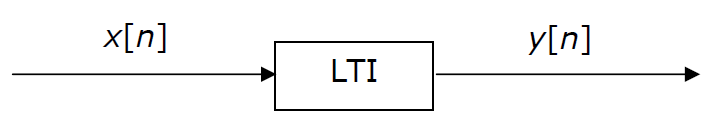

In [ ]:
n = np.arange(-2, 6, 1)

x = np.array([0,0,1,1,1,0,0,0])

y0 = np.array([0,0,1,1,1,0,0,0])
y1 = np.array([0,0,0,1,1,1,0,0])
y2 = np.array([0,0,0,0,1,1,1,0])

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.stem(n, x)
ax1.set_ylim([-0.5, 3.5])
ax1.set_xlabel("n")
ax1.set_title('Entrée $x[n]$')


ax2 = plt.subplot(1,2,2)
ax2.stem(n, y0+y1+y2)
ax2.set_ylim([-0.5, 3.5])
ax2.set_xlabel("n")
ax2.set_title('Sortie $y[n]$')

plt.tight_layout()

**Figure 9.** Entrée-sortie pour le système de la figure 8.

On voit donc qu’en remplaçant l’entrée $x[n]$ par une somme d’impulsions décalées (éventuellement d’amplitudes différentes…),  on obtient la sortie en superposant la réponse à chacune de ces impulsions (somme de réponses impulsionnelles décalées).

Ceci se formalise comme suit :

$$
y[n]=\sum_{k=-\infty}^{\infty} x[k] h[n-k]
$$

où $h[n-k]$ est la réponse impulsionnelle décalée de $k$ échantillons (vers la droite), et $x[k]$ est I'amplitude de l'échantillon $k$ du signal d'entrée. Ainsi, $h[n-k]$ est la réponse à une impulsion (d'amplitude 1 ) qui se produit à $n=k$, et donc $x[k] h[n-k]$ est la réponse de l'échantillon $x[k]$ qui est à la position $n=k$. On fait la somme sur toutes les valeurs possibles de $k$, i.e. que I'on considère tous les échantillons $x[k]$ (de $k=-\infty$ à $k=\infty$ ) de $x[n]$.

Dans I'exemple ci-dessus, on a uniquement 3 échantillons non-nuls en entrée, et donc la somme $n^{\prime} a$ qu'à prendre en compte les valeurs $k=0$, $1$ et $2$ uniquement, ce qui donne:

$$
\begin{aligned}
    y[n] & =\sum_{k=-\infty}^{\infty} x[k] h[n-k] \\
    & =\sum_{k=0}^2 x[k] h[n-k] \\
    & =x[0] h[n]+x[1] h[n-1]+x[2] h[n-2] \\
    & =1 h[n]+1 h[n-1]+1 h[n-2]
    \end{aligned}
$$

où $h[n]$ est la réponse impulsionnelle pour le système de la figure 8, et $h[n-k]$ est cette même réponse impulsionnelle mais décalée de $k$ échantillons vers la droite (en retard...).
Notez que si les échantillons de $x[n]$ avaient été $\left[\begin{array}{lll}1 & 2 & -1\end{array}\right]$ au lieu de $\left[\begin{array}{lll}1 & 1 & 1\end{array}\right]$ comme montré sous la figure 8, la réponse du système, selon l'équation ci-dessus, aurait plutôt été :

$$
\begin{aligned}
    y[n] & =\sum_{k=-\infty}^{\infty} x[k] h[n-k] \\
    & =\sum_{k=0}^2 x[k] h[n-k] \\
    & =x[0] h[n]+x[1] h[n-1]+x[2] h[n-2] \\
    & =1 h[n]+2 h[n-1]-1 h[n-2]
\end{aligned}
$$

Cette équation est justement ce qu’on appelle la somme de convolution :

<div align="center">

$$y[n]=\sum_{k=-\infty}^{\infty} x[k] h[n-k]$$

</div> 

Notez que la forme de la somme de convolution est essentiellement la même que l’intégrale de convolution pour les signaux à temps continu.

Exercez vous à la convolution avec les deux exemples ci-dessous. On ne donne pas la solution, mais vous pouvez vérifier votre réponse avec la fonction *convolve* de la librairie Python Numpy.



### Exercice 1

Un système discret LTI a une réponse impulsionnelle montrée à la figure suivante :

In [ ]:
n = np.arange(-2, 6, 1)
x = [0, 0, 1, 0.8, 0.6, 0.4, 0.2, 0]

plt.figure()
plt.stem(n, x)
plt.xlabel('n')
plt.title('Réponse impulsionelle $h[n]$')

Calculez, par la méthode de la convolution, la réponse de ce système au signaux $x[n]$ suivants (affichez le résultat):

>(a) $$x[n] = \begin{cases}1 & \text{ pour } 0 \le n \le 3 \\ 0 & \text { ailleurs } \end{cases}$$

>(b) $$x[n] = \begin{cases}1 & \text{ pour } n = 0 \\ -1 & \text { pour } n = 1 \\ 0 & \text { ailleurs }\end{cases}$$


### Exercice 2

Un signal $y[n]$ est obtenu en convoluant un signal $x[n]$ dont les seuls échantillons non-nuls sont entre $n=2$ et $n=7$ inclusivement, et un signal $h[n]$ dont les seuls échantillons non-nuls sont entre $n=1$ et $n=3$.

>(a)	Quelle sera la durée (en échantillons) du signal $y[n]$?

>(b)	Quelles seront les positions $N1$ et $N2$ du premier échantillon non-nul et du dernier échantillon non-nul de $y[n]$?


## Convolution avec la librairie Python Numpy

Parmi les nombreuses fonctions de la librairie Numpy, on retrouve la fonction de convolution appelée simplement *convolve*.

Cette fonction prend deux vecteurs en entrée (les deux signaux à convoluer) et retourne le résultat de la convolution dans un autre vecteur.  Par défaut la fonction utilise le mode "full" (pour convolution complète) qui correspond à ce que vous obtiendrez de manière arithmétique.

Par exemple, le code Python suivant montre comment convoluer un signal $x[n]$ qui vaudrait $1$ pour ses $3$ premiers échantillons, et $0$ ailleurs, avec un signal $h[n]$ qui aurait la même forme.

```Python
x = [1, 1, 1]
h = [1, 1, 1]

y = np.convolve(x, h)
 
print("y = " + str(y))
```

In [ ]:
x = [1, 1, 1]
h = [1, 1, 1]

y = np.convolve(x, h)
 
print("y = " + str(y))

Quel résultat obtiendrait-on si le signal $x[n]$ était retardé d’un échantillon? Bien évidemment, la sortie serait la même, mais retardée aussi d’un échantillon. C’est ce que montre le code suivant, où le premier « $0$ » du résultat $y[n]$ implique un décalage de $1$ échantillon de tout le reste du signal, qui demeure inchangé par rapport au résultat ci-haut :

```Python
x = [0, 1, 1, 1]
h = [1, 1, 1]

y = np.convolve(x, h)

print("y = " + str(y))
```

In [ ]:
x = [0, 1, 1, 1]
h = [1, 1, 1]

y = np.convolve(x, h)

print("y = " + str(y))

(C’est bien le même $x$ que dans le code précédente). On ne va pas utiliser cette fonction de déconvolution dans les systèmes à temps continu.

In [ ]:
n = np.arange(-3, 7, 1)
x = [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
h = [0, 0, 0, 1, 0.5, 0.5, 0, 0, 0, 0]

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.stem(n, x)
ax1.set_ylim([-0.5, 1.5])
ax1.set_xlabel("n")
ax1.set_title('$x[n]$')

ax2 = plt.subplot(1,2,2)
ax2.stem(n, h)
ax2.set_ylim([-0.5, 1.5])
ax2.set_xlabel("n")
ax2.set_title('$h[n]$')

plt.tight_layout()


Puisqu’on désire considérer $k$ comme la variable temporelle, on va plutôt afficher ces signaux en fonction de $k$, i.e. $x[k]$ et $h[k]$ :

In [ ]:

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

ax1 = plt.subplot(1,2,1)
ax1.stem(n, x)
ax1.set_ylim([-0.5, 1.5])
ax1.set_xlabel("k")
ax1.set_title('$x[k]$')

ax2 = plt.subplot(1,2,2)
ax2.stem(n, h)
ax2.set_ylim([-0.5, 1.5])
ax2.set_xlabel("k")
ax2.set_title('$h[k]$')

plt.tight_layout()

Pour l’instant, ce n’est qu’un changement de variable (on change $n$ pour $k$). Mais ceci nous permet maintenant de considérer $x[k]$ dans la somme de convolution comme un signal complet (et non comme un échantillon unique du signal $x[n]$ au temps $n=k$). De plus, la fonction $h[n-k]$ s’interprète autrement si on considère $k$, et non $n$, comme la variable de temps: c’est la fonction $h[k]$, que l’on inverse dans le temps (pour obtenir $h[-k]$), et à laquelle on applique un décalage $n$ (pour obtenir finalement $h[n-k]$).

Dans quel sens est le décalage $n$? (un retard – i.e. vers la droite – ou une avance – i.e. vers la gauche). Eh bien, vers la droite si $n$ est positif, et vers la gauche si $n$ est négatif. Pensez-y : si vous connaissez la fonction $h[-k]$, et que vous désirez avoir sa correspondance avec les échantillons de $h[-k+1]= h[1-k]$ $(n=1)$, vous obtenez

$$
\begin{array}{lll}
    k & h[-k] & h[-k+1] \\
      &      &      \\
    0 & h[0] & h[1] \\
    1 & h[-1] & h[0] \\
    2 & h[-2] & h[-1] \\
    3 & h[-3] & h[-2] \\
    \ldots & &
\end{array}
$$

Ainsi, chaque échantillon de $h[-k]$ est décalé de 1 échantillon vers la droite (retard) dans $h[-k+1]$. En général, donc, la fonction $h[-k+n]$ est retardée de $n$ échantillons par rapport à la fonction $h[-k]$.

Nous pouvons maintenant effectuer la convolution, selon ce deuxième point de vue, qui consiste, rappelons-le, à faire le produit des fonctions $x[k]$ et $h[n-k]$, puis de faire la somme, pour obtenir l’échantillon n de la sortie $y[n]$.

Les figures suivantes résument le processus pour $n$ entre $0$ et $4$ inclusivement, pour les signaux $x[n]$ et $h[n]$ de la page précédente. La figure du haut à gauche montre le signal $x[k]$ (changement de variable $n$ pour $k$). Les figures de la colonne de gauche, sous $x[k]$, montrent les différentes versions de $h[n-k]$ pour $n$ entre $0$ et $4$ inclusivement, et les figures de droite montrent la valeur de $y[n]$ correspondante, de même que sa position dans le temps (i.e. à l’échantillon $n$). En abscisse, on a la variable $k$, entre $–3$ et $6$. Vérifiez que $y[n]$ est égal à la somme, sur toutes les valeurs de $k$, du produit entre $x[k]$ et $h[n-k]$.


In [ ]:
K = [-3, -2, -1, 0, 1 , 2, 3, 4, 5, 6]
x = [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
h = [0, 0, 0, 1, 0.5, 0.5, 0, 0, 0, 0]
y = np.zeros(len(x))

offset_k = 3 # offset de 3 car K commence à -3
h = h + [0] # padding avec "0" pour tenir compte de l'offset

# affichage
fig, axs = plt.subplots(6, 2, figsize=(6, 8))
axs = axs.ravel()
axs[0].stem(K, x)
axs[0].set_xlim([-3, 6])
axs[0].set_ylim([0, 2])
axs[1].axis('off')

for n in range(5):  # pour n entre 0 et 4 inclusivement
    temp_prod = []
    temp_h = np.zeros(len(h))
    for i, k in enumerate(K):
        temp_h[i] = h[n-k+offset_k]
        temp_prod.append(x[i]*temp_h[i])  # produit par valeur de k

    temp_y = np.sum(temp_prod) # somme des produits
    y[n+offset_k] = temp_y  

    # affichage
    axs[2*n+2].stem(K, temp_h[:-1])
    axs[2*n+2].set_xlim([-3, 6])
    axs[2*n+2].set_ylim([0, 2])

    temp_y_plot = np.zeros(len(x))
    temp_y_plot[n+offset_k] = temp_y 
    axs[2*n+3].stem(K, temp_y_plot)
    axs[2*n+3].set_xlim([-3, 6])
    axs[2*n+3].set_ylim([0, 2])

plt.tight_layout()



Illustration de la convolution en sommant le produit $x[k] h[n-k]$


## La convolution pour les signaux continus : un exemple

En comparant la somme de convolution

$$
y[n]=\sum_{k=-\infty}^{\infty} x[k] h[n-k]
$$

à l’intégrale de convolution 

$$y(t)=\int_{\tau=-\infty}^{\infty} x(\tau) h(t-\tau) d \tau$$
 

on remarque que leur forme est identique. La différence, bien entendu, est que $\tau$ et $t$ son des variables continues, alors que $k$ et $n$ sont des variables discrètes (valeurs entières uniquement). De plus, on retrouve l’élément $d\tau$ dans l’intégrale, puisqu’on y fait une « somme » d’un nombre infini de fonctions. Mais autrement, leur expression est identique. 

Notez qu’on utilise en général la notation

$$
x(t) \ * \ h(t)
$$

pour signifier l’intégrale de convolution des signaux $x(t)$ et $h(t)$. Ici, le symbole « $*$ » ne représente pas le produit, mais bien l’intégrale de convolution de l’équation encadrée ci-haut.

La convolution permet de déterminer la réponse $y(t)$ d’un système à tout signal d’entrée $x(t)$. Il suffit de connaître la réponse impulsionnelle $h(t)$ du système. L’exemple suivant permettra d’illustrer le principe pour un circuit simple, le circuit RC.

Considérez donc le circuit RC suivant :

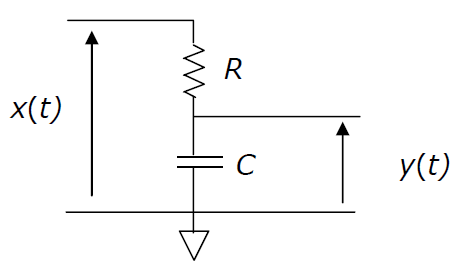

où $R = 1 k \Omega $, $C = 1 \mu F $, et $x(t)$ et $y(t)$ sont respectivement la tension en entrée et la tension en sortie. Le circuit est initialement au repos ($x(0) = 0$ et $y(0) = 0$).

Déterminez, par la méthode de la convolution, la réponse de ce circuit au signal $x(t)$ montré ci-dessous :
<a class="anchor" name="entree"></a>

In [ ]:
dt = 1/100000
t = np.arange(-2, 5, dt)/1000

x = np.piecewise(t, [(t >= 0)*(t <= 3/1000), (t < 0)*(t > 3/1000)], [1, 0])

fig = plt.figure()
plt.plot(t*1000, x)
plt.ylim([-1, 2])
plt.xlim([-2, 5])
plt.xlabel('t (millisecondes)')
plt.ylabel('x(t)')

En sachant que la réponse impulsionnelle du circuit est donnée par

$$
h(t)=\frac{1}{R C} e^{-t / R C} u(t)
$$

Avec les valeurs de $R$ et $C$ données ci-dessus, on a

$$
h(t)=1000 e^{-1000 t} u(t)
$$

La fonction $u(t)$ est la fonction échelon, qui vaut $0$ pour les temps négatifs et $1$ pour $t>0$.

La figure suivante montre les premiers $5$ ms de la réponse à l’impulsion $h(t)$ du circuit :
<a class="anchor" name="repimp"></a>

In [ ]:
dt = 1/10000    # incrément temporel (élément différentiel)
t = np.arange(-2, 5, dt)/1000   # échelle de temps

h = 1000*np.exp(-1000*t)    # réponse impulsionnelle

fig = plt.figure()
plt.plot(t*1000, h)
plt.ylim([0, 1000])
plt.xlim([0, 5])
plt.xlabel('t (millisecondes)')
plt.ylabel('h(t)')



Pour obtenir la réponse à l’entrée $x(t)$, il suffit maintenant de convoluer $x(t)$ avec $h(t)$ montré ci-dessus. Graphiquement, on peut observer que le résultat de cette convolution sera différent selon que $0<t<3$ ms ou $t>3$ ms (et pour $t<0$, le résultat sera nul). Ceci peut se voir dans la figure ci-dessous, où on voit $x(\tau)$ et $h(t-\tau)$ pour différentes valeurs de $\tau$. 

La figure du haut montre le signal $x(\tau)$ (notez le changement de variable $t$ pour $\tau$). Les $4$ figures suivantes montrent $h(t-\tau)$ pour $4$ valeurs du temps, soit $t=0$, $1$, $3$ et $5$ ms respectivement. L’axe horizontal est le temps $\tau$, en millisecondes.

La sortie $y(t)$ au temps $t$ est simplement le produit de $x(\tau)$ avec $h(t-\tau)$, intégré sur toutes les valeurs du temps $\tau$ (définition de la convolution). Dans cet exemple, $x(\tau)$ étant non nulle seulement pour $\tau$ compris entre $0$ et $3$ ms, le produit $x(\tau) h(t-\tau)$ ne peut être non nul que sur cet intervalle. Plus précisément, le produit $x(\tau)h(t-\tau)$ est nul partout sauf entre $\tau=0$ et $\tau=t$ lorsque le décalage $t$ est entre $0$ et $3$ ms, et entre $\tau=0$ et $\tau=3$ ms lorsque le décalage $t$ est plus grand que $3$ ms.



In [ ]:
dt = 1/10000    # incrément temporel (élément différentiel)
t = np.arange(-5, 5, dt)/1000   # échelle de temps

x = np.piecewise(t, [(t >= 0)*(t <= 3/1000), (t < 0)*(t > 3/1000)], [1, 0])
h = np.piecewise(t, [t<0, t>=0], [lambda t: 1000*np.exp(1000*t), 0])

fig, axs = plt.subplots(5, 1, figsize=(6, 8))
axs = axs.ravel()
axs[0].plot(t*1000, x)
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-1, 2])

axs[1].plot(t*1000, h)
axs[1].set_xlim([-5, 5])
axs[1].set_ylim([0, 1100])

lag_list = [1/1000, 3/1000, 5/1000]
for i, lag in enumerate(lag_list):
    axs[i+2].plot(t*1000, np.roll(h,1000*int(lag/dt)))
    axs[i+2].set_xlim([-5, 5])
    axs[i+1].set_ylim([0, 1100])

plt.tight_layout()


On a donc $2$ intégrales de convolution, selon la valeur de $t$ :

1. Pour $t$ entre $0$ et $3$ ms , on a

$$
\begin{aligned}
    y_1(t) & =\int_{\tau=0}^t x(\tau) h(t-\tau) d \tau \\
    & =\int_{\tau=0}^t(1) 1000 e^{-1000(t-\tau)} d \tau \\
    & =\left.\frac{1000 e^{-1000(t-\tau)}}{1000}\right|_{\tau=0} ^t \\
    & =1-e^{-1000 t}
\end{aligned}
$$

2. Pour $t$ plus grand que $3$ ms, on a

$$
\begin{aligned}
    y_2(t) & =\int_{\tau=0}^{0.003} x(\tau) h(t-\tau) d \tau \\
    & =\int_{\tau=0}^{0.003}(1) 1000 e^{-1000(t-\tau)} d \tau \\
    & =\left.\frac{1000 e^{-1000(t-\tau)}}{1000}\right|_{\tau=0} ^{0.003} \\
    & =e^{-1000(t-0.003)}-e^{-1000 t}
\end{aligned}
$$


Et pour $t < 0$, la réponse $y(t)$ est nulle.

La figure suivante montre la réponse $y(t)$, formée de $y1(t)$ pour $t$ entre $0$ et $3$ ms, suivie de $y2(t)$ pour $t > 3$ ms.

In [ ]:
dt = 1/10000    # incrément temporel (élément différentiel)
t = np.arange(-2, 7, dt)/1000   # échelle de temps

y1 = lambda t: 1-np.exp(-1000*t)    # y1(t) 
y2 = lambda t: np.exp(-1000*(t-0.003))-np.exp(-1000*t)  # y2(t) 

y = np.piecewise(t, [t<0, (t>=0)*(t<=3/1000), t>3/1000], [0, y1, y2])   # réponse y(t), formée de y1(t) pour t entre 0 et 3 ms, suivie de y2(t) pour t > 3 ms. 

fig = plt.figure()
plt.plot(t*1000, y)
plt.xlim([-2, 7])
plt.ylim([0, 1])
plt.xlabel('t (millisecondes)')
plt.title('Réponse y(t)')

plt.annotate('y1(t)', xy=[t[int(len(t)/3)]*1000, y[int(len(t)/3)]], xycoords='data',
            xytext=(0.1, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', headwidth=8 , width=0.01),
            horizontalalignment='left', verticalalignment='top',
            )
plt.annotate('y2(t)', xy=[t[2*int(len(t)/3)]*1000, y[2*int(len(t)/3)]], xycoords='data',
            xytext=(0.9, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', headwidth=8 , width=0.01),
            horizontalalignment='right', verticalalignment='top',
            )



On observe que la durée du pulse rectangulaire en [entrée](#entree) est trop courte pour que le condensateur se charge complètement lors de la première phase de la réponse ($y1(t)$). Ceci est cohérent avec la forme de la [réponse impulsionnelle](#repimp) $h(t)$ du circuit, qui ne devient presque nulle qu’après $5$ ms, alors que le pulse en entrée ne dure que $3$ ms. La définition même de la convolution nous permet maintenant de comprendre que la durée de la période transitoire de la réponse d’un système est étroitement liée à la durée de la réponse impulsionnelle du système.

On observe dans la deuxième phase de la réponse ($y2(t)$), on observe essentiellement la forme de la réponse impulsionnelle, puisque l’entrée devient tout à coup nulle à partir de $3$ ms.

Avec un peu de pratique, la convolution n’aura plus de secrets pour vous. Assurez-vous de faire quelques [exercices](#exercices) (voir à la fin de ce document) pour vous « faire la main ». 


## Utiliser Numpy pour approximer l’intégrale de convolution

Dans la section 5.0, on a vu comment utiliser la fonction Numpy convolve pour convoluer deux signaux à temps discret. On peut utiliser Numpy aussi pour obtenir une bonne estimation numérique de l’intégrale de convolution entre deux signaux analogiques. Pour voir ceci, nous allons résoudre avec Numpy l’exemple précédent avec le circuit RC.

Rappelons que le signal d’entrée était donné par 

$$
x[n] = \begin{cases}1 & \text{ pour } 0 \le n \le 3 \\ 0 & \text { ailleurs } \end{cases}
$$

et que la réponse impulsionnelle de ce circuit est donnée par

$$
h(t)=1000 \exp (-1000 t) u(t)
$$

En notant que la somme de convolution

$$
y[n]=\sum_{k=-\infty}^{\infty} x[k] h[n-k]
$$

et I'intégrale de convolution

$$
y(t)=\int_{\tau=-\infty}^{\infty} x(\tau) h(t-\tau) d \tau
$$

ont la même forme, sauf pour l'élément différentiel $d \tau$, on peut déduire que pour approximer l'intégrale par la somme, il suffit de multiplier le résultat de la somme par l'élément $d \tau$. Ainsi, I'exemple de code Python suivant montre comment on obtient par convolution la réponse du circuit $R C$ à l'entrée $x(t)$ définie plus haut. Notez qu'on doit choisir un incrément temporel assez petit pour pouvoir «commencer à le considérer» comme un élément différentiel.

```Python
dt = 0.005/1000 # incrément temporel (élément différentiel)
t = np.arange(0, 0.005, dt)    # échelle de temps

x = np.concatenate((np.ones(600) , np.zeros(400)))  # signal d’entrée (version discrète)
h = 1000*np.exp(-1000*t)    # réponse impulsionnelle

y = np.convolve(x, h) * dt    # intégrale de convolution

tt = np.arange(0, 2*0.005-dt, dt)  # échelle de temps pour la sortie

fig = plt.figure()

ax1 = plt.subplot(3,1,1)
ax1.plot(1000*t, x)
ax1.set_xlim([0, 5])
ax1.set_ylim([-1, 2])
ax1.set_ylabel('x(t)')

ax2 = plt.subplot(3,1,2)
ax2.plot(1000*t, h)
ax2.set_xlim([0, 5])
ax2.set_ylabel('h(t)')

ax3 = plt.subplot(3,1,3)
ax3.plot(1000*tt, y)
ax3.set_xlim([0, 10])
ax3.set_ylabel('y(t)')
ax3.set_xlabel('t (millisecondes)')

plt.tight_layout()
```

In [ ]:
dt = 0.005/1000 # incrément temporel (élément différentiel)
t = np.arange(0, 0.005, dt)    # échelle de temps

x = np.concatenate((np.ones(600) , np.zeros(400)))  # signal d’entrée (version discrète)
h = 1000*np.exp(-1000*t)    # réponse impulsionnelle

y = np.convolve(x, h) * dt    # intégrale de convolution

tt = np.arange(0, 2*0.005-dt, dt)  # échelle de temps pour la sortie

fig = plt.figure()

ax1 = plt.subplot(3,1,1)
ax1.plot(1000*t, x)
ax1.set_xlim([0, 5])
ax1.set_ylim([-1, 2])
ax1.set_ylabel('x(t)')

ax2 = plt.subplot(3,1,2)
ax2.plot(1000*t, h)
ax2.set_xlim([0, 5])
ax2.set_ylabel('h(t)')

ax3 = plt.subplot(3,1,3)
ax3.plot(1000*tt, y)
ax3.set_xlim([0, 10])
ax3.set_ylabel('y(t)')
ax3.set_xlabel('t (millisecondes)')

plt.tight_layout()


On note qu’on a d’abord définit l’élément différentiel `dt`. On l’a pris égal à `1/1000e` de la durée d’observation du signal d’entrée (i.e. 5 ms). Ca veut dire que les versions discrètes des signaux à convoluer seront des vecteurs comportant 1000 valeurs. Plus `dt` sera petit, meilleure sera l’approximation de l’intégrale, mais plus le temps de calcul sera long. On suggère de s’en tenir à quelques milliers d’échantillons au plus.

On a ensuite définit une échelle de temps, allant de 0 à 0.005 seconde. Puis, on définit les signaux à convoluer, i.e. d’abord `x` puis `h`. Pour `x`, comme c’est une onde rectangulaire de durée finie, on le définit avec les fonctions Numpy zeros et ones et la fonction de concaténation (on aurait également pu construire un vecteur rempli de « 1 » pour ensuite forcer les 400 dernières valeurs à 0 ou utiliser la fonction Numpy `piecewise`). Pour `h`, comme on a son expression analytique (une exponentielle décroissante) on la définie avec la fonction `exp` de Numpy.

Ensuite, lorsqu’on a discrétisé les signaux à convoluer, on appliquer la fonction convolve à ceux-ci, en n’oubliant pas de multiplier le tout par l’élément différentiel `dt` (qui se trouve dans l’intégrale). Le résultat, noté `y`, est la version numérique approximée du résultat de l’intégrale de convolution appliquée à `x` et `h`.

Notez que la durée de la sortie est la somme des durées de `x` et de `h`. C’est pour cette raison que nous avons redéfinit l’échelle de temps `tt` pour afficher la sortie `y` en fonction du temps. Le résultat de cette convolution est montré ci-dessous. On note que c’est le même résultat que celui obtenu « au long » dans l’exercice sur le réseau RC (le temps est en milliseconds, sur l’abcisse). On a donc montrée qu’on peut utiliser Python pour obtenir une version numérique (et approximative) de l’intégrale de convolution.

```Python
fig = plt.figure()
plt.plot(1000*tt, y)
plt.xlim([0, 10])
plt.ylim([0, 1])
plt.ylabel('y(t)')
plt.xlabel('t (millisecondes)')
```

In [ ]:

fig = plt.figure()
plt.plot(1000*tt, y)
plt.xlim([0, 10])
plt.ylim([0, 1])
plt.ylabel('y(t)')
plt.xlabel('t (millisecondes)')

On peut faire un autre exemple, pour montrer l’intérêt de l’approximation numérique. Supposons qu’on désire connaître la réponse à ce même circuit RC si l’entrée est une sinusoïde de 1000 Hz redressée double alternance. On prendra ici une durée d’observation de 10 millisecondes et un incrément différentiel de 1/1000e de la durée d’observation. Le code Python est le suivant (notez l’usage de la fonction `abs` pour redresser le signal – dans un circuit analogique, un pont de diodes ou une structures active intégrant des diodes serait utilisé pour redresser le signal).

```Python
dt = 0.01/1000 # incrément temporel (élément différentiel)
t = np.arange(0, 0.01, dt)    # échelle de temps

x = np.sin(2*np.pi*1000*t)  # signal d’entrée discrétisé
xa = np.abs(x)              # signal d’entrée redressé
h = 1000*np.exp(-1000*t)    # réponse impulsionnelle

y = np.convolve(xa, h) * dt    # intégrale de convolution

plt.figure()
plt.plot(1000*t, y[:len(x)])
plt.xlim([0, 10])
plt.ylim([0, 0.7])
plt.ylabel('y(t)')
plt.xlabel('t (millisecondes)')
```

In [ ]:
dt = 0.01/1000 # incrément temporel (élément différentiel)
t = np.arange(0, 0.01, dt)    # échelle de temps

x = np.sin(2*np.pi*1000*t)  # signal d’entrée discrétisé
xa = np.abs(x)              # signal d’entrée redressé
h = 1000*np.exp(-1000*t)    # réponse impulsionnelle

y = np.convolve(xa, h) * dt    # intégrale de convolution

plt.figure()
plt.plot(1000*t, y[:len(x)])
plt.xlim([0, 10])
plt.ylim([0, 0.7])
plt.ylabel('y(t)')
plt.xlabel('t (millisecondes)')

Ce dernier exemple, et la forme montrée ci-dessus, sont très similaires à ce que vous rencontrerez à un point précis du circuit de l’unité 2.

Notez que si on avait affiché la réponse `y` en entier, on aurait obtenu un signal qui décroît dans sa deuxième moitié. Comme on suppose que la sinusoïde redressée est « infinie », i.e. qu’elle se poursuit sans s’arrêter, alors seule la partie de la réponse qui correspond à la durée de l’entrée observée a du sens dans ce contexte.

Pour terminer ce document sur la convolution, on vous suggère de résoudre les exercices de la section ci-dessous. Vous pouvez facilement vérifier vos réponses avec vos nouvelles compétences Python en convolution.

## Autres exercices sur la convolution
<a class="anchor" name="exercices"></a>
Sans faire le calcul de l’intégrale, i.e. uniquement en dessinant les signaux (possiblement inversés et décalés dans le temps), obtenez le résultat $y(t)$ de la convolution des paires de signaux $x(t)$ et $h(t)$ suivants.

>(a)

<img src="Images/05_chap9_a.png" width="960px" height="400px">

<details>
<summary><b>Réponses</b></summary>

<img src="Images/05_chap9_a_resultat.png" width="480px" height="400px">

</details>

Refaites le même exercice si la durée de $h(t)$ $1$ sec au lieu de $0.5$ sec.

>(b)

<img src="Images/05_chap9_b.png" width="960px" height="400px">

<details>
<summary><b>Réponses</b></summary>

<img src="Images/05_chap9_b_resultat.png" width="480px" height="400px">
    
</details>


>(c) Convolution avec des impulsions de Dirac.

On vous demande maintenant de convoluer $x(t)$ et $h(t)$ montrés ci-dessous, où $h(t)$ est formé de deux impulsions de Dirac à $t = 3$ et à $t = -3$. Puisqu’on ne peut pas montrer de signaux infinis (…), $h(t)$ a une amplitude maximale dans le graphique ci-dessous. Assumez cependant qu’il est formé de deux impulsions idéales, i.e. infiniment étroite, d’amplitude infiniment élevée, et de surface unitaire.

<img src="Images/05_chap9_c.png" width="960px" height="400px">

<details>
<summary><b>Réponses</b></summary>

<img src="Images/05_chap9_c_resultat.png" width="480px" height="400px">
    
</details>

Les solutions sont disponibles [ici](05_La_convolution_solution_chap9.ipynb).

Conclusion : 

>convoluer un signal $x(t)$ avec une série d’impulsions de Dirac ($h(t)$) produit un signal $y(t)$ de même forme que $x(t)$, mais reproduit et centré à chacune des impulsions de $h(t)$

Notez que si $x$ et h avaient été dans le domaine des fréquences (des spectres), on aurait eu le même résultat (on peut convoluer des spectres entres eux – eh oui – la convolution n’est pas uniquement réservée au domaine du temps…

Ainsi, on a une nouvelle interprétation de la modulation AM : lorsqu’on multiplie entre eux deux signaux ($x(t)$ et la porteuse $p(t)$), ceci revient à convoluer leurs spectres… En effet, si $x$ et h montrés ci-dessus avaient été des spectres, le signal $y$ est le résultat de la convolution de $x$ avec $h$, mais c’est aussi le spectre du signal modulé en amplitude.

Ceci constitue une propriété centrale de la convolution :

>Multiplier (moduler) deux signaux dans un domaine (par exemple, le temps) revient à les convoluer dans l’autre domaine (les fréquences).

Elle a son dual dans les fréquences : multiplier deux spectres revient à convoluer les signaux dans le temps. On a donc:
    
$$
\begin{array}{ll}
f(t) & F(\omega) \\
 & & \\
 f_1(t) * f_2(t) & F_1(\omega) F_2(\omega) \\ 
 f_1(t) f_2(t) & {[1 /(2 \pi)]\left[F_1(\omega) * F_2(\omega)\right]}
\end{array}
$$

Sur la première ligne, $f_1(t) * f_2(t)$ représente la convolution de $f_1(t)$ avec $f_2(t)$ (un filtrage...) ce qui revient à multiplier leurs spetres entre eux. Sur la deuxième ligne, $f_1(t) f_2(t)$ est simplement le produit $f_1(t)$ avec $f_2(t)$ (modulation AM), ce qui revient à convoluer leurs spectres.
    
